 # Quora Question Pairs
 - Capstone Project: Eric Canull

In [1]:
# Import libraries
import datetime
import logging
import os
import warnings
from time import time

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from scipy.spatial.distance import (
    braycurtis, canberra, chebyshev, cityblock, cosine, euclidean, jaccard,
    minkowski, sqeuclidean)
from scipy.stats import kurtosis, skew
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (
    KFold, cross_val_predict, cross_val_score, train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from tqdm import tqdm_notebook

import xgboost as xgb
from graphs import heatmap_chart, pie_chart, histogram
from textcleaner import clean_text, drop_null, print_questions

warnings.filterwarnings("ignore")
start_nb = time()


C:\Users\ericc\Anaconda2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Global Variables
TRAIN_FILE = "data/train.csv"
TEST_FILE = "data/test.csv"
GOOGLE_EMBEDDING_FILE = "data/googlenews/GoogleNews-vectors-negative300.bin.gz"
GLOVE_EMBEDDING_FILE = 'data/glove.6B/glove.6B.300d.txt'
GLOVE_WORD2VEC_FILE = 'data/glove.6B/word2vec/glove.6B.300d.word2vec.txt'
GLOVE_WORD2VEC_MODEL = "models/glove_300d_word2vec.model"
GLOVE_WORD2VEC_NORM_MODEL = "models/glove_300d_norm_word2vec.model"
Q1_WMD_TRAINING_DATA_FILE = "data/npy/q1_wmd_train.npy"
Q2_WMD_TRAINING_DATA_FILE = "data/npy/q2_wmd_train.npy"
EMBEDDING_DIM = 300

stops = set(stopwords.words("english"))


In [3]:
# Import files
pd.options.mode.chained_assignment = None
train_df = pd.read_csv(filepath_or_buffer=TRAIN_FILE)
test_df = pd.read_csv(filepath_or_buffer=TEST_FILE)


In [4]:
# Loading into a Gensim Word2Vec model class may take several minutes.
if not os.path.exists(GLOVE_EMBEDDING_FILE):
    raise FileNotFoundError(
        "Warning! You need to download the Glove embeddings")

if not os.path.exists(GLOVE_WORD2VEC_MODEL):
    glove2word2vec(GLOVE_EMBEDDING_FILE, GLOVE_WORD2VEC_FILE)
    word2vec = KeyedVectors.load_word2vec_format(GLOVE_WORD2VEC_FILE, binary=False)
else:
    word2vec = gensim.models.KeyedVectors.load(GLOVE_WORD2VEC_MODEL)


 ## L<sup>2</sup> unit-normalized WMD
 ### Necessary for computing cosine similiarity

In [5]:
# Loading into a Gensim Word2Vec model class may take several minutes.
if not os.path.exists(GLOVE_WORD2VEC_NORM_MODEL):
    norm_word2vec = word2vec
    norm_word2vec.init_sims(replace=True)
else:
    norm_word2vec = gensim.models.KeyedVectors.load(GLOVE_WORD2VEC_NORM_MODEL)


In [6]:
# Null counts in training set
# train_df.isnull().sum()
train_df[train_df.isnull().any(axis=1)]


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
# Null counts in test set
# test_df.isnull().sum()
test_df[test_df.isnull().any(axis=1)]


,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1046690,1046690,NaN,How I what can learn android app development?
1270024,1270024,How I can learn app development?,NaN
1461432,1461432,NaN,How distinct can learn android app development?
2345796,"life in dublin?""",NaN,NaN
2487703,1270024,How I can learn app development?,NaN
2679111,1461432,NaN,How distinct can learn android app development?


In [8]:
# Drop rows with null values
train_df = drop_null(train_df)
test_df = drop_null(test_df)


In [9]:
# Training dataset summary statistics
train_df.describe()


,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


 ## Transform questions into vectors

In [11]:
def wmd(q1, q2):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1 = [w for w in q1 if w not in stops and w.isalpha()]
    q2 = [w for w in q2 if w not in stops and w.isalpha()]
    return word2vec.wmdistance(q1, q2)


def norm_wmd(q1, q2):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1 = [w for w in q1 if w not in stops and w.isalpha()]
    q2 = [w for w in q2 if w not in stops and w.isalpha()]
    return norm_word2vec.wmdistance(q1, q2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if w not in stops]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(norm_word2vec[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())


In [12]:
# transform questions into vectors
question1_vectors = np.zeros((train_df.shape[0], EMBEDDING_DIM))
for i, q in enumerate(tqdm_notebook(train_df.question1.values)):
    question1_vectors[i, :] = sent2vec(q)


In [13]:
# print q1 embedded matrix
question1_vectors


array([[-0.00584324, -0.02602208,  0.04017816, ..., -0.07484402,
         0.03171926, -0.01852482],
       [ 0.02431811,  0.0071606 , -0.03193918, ...,  0.01777791,
         0.06144963, -0.02568657],
       [-0.0677357 ,  0.03937946,  0.02036542, ...,  0.0224138 ,
        -0.03669912, -0.04505108],
       ...,
       [-0.04112595,  0.07582713, -0.07168064, ..., -0.03829526,
        -0.0102665 , -0.03911567],
       [-0.06327954, -0.00269803,  0.03565133, ..., -0.03753009,
         0.00810145,  0.0094814 ],
       [-0.0405001 ,  0.02862247, -0.0054011 , ...,  0.01718741,
        -0.03678865,  0.11604238]])

In [14]:
# transform questions into vectors
question2_vectors = np.zeros((train_df.shape[0], EMBEDDING_DIM))
for i, q in enumerate(tqdm_notebook(train_df.question2.values)):
    question2_vectors[i, :] = sent2vec(q)


In [15]:
# print q2 embedded matrix
question2_vectors


array([[-0.00261541, -0.00936061,  0.04245444, ..., -0.07011838,
         0.02325039, -0.01456384],
       [ 0.00229112,  0.01393233, -0.05804598, ..., -0.08214046,
         0.03205749,  0.02155086],
       [-0.03208913,  0.03309121,  0.05767504, ...,  0.02487843,
        -0.0078695 , -0.09010499],
       ...,
       [ 0.00744008,  0.04165791, -0.05956756, ...,  0.0128552 ,
         0.06025847, -0.06757131],
       [ 0.00799632,  0.06443305, -0.02947297, ..., -0.02756036,
        -0.01114639,  0.03927977],
       [-0.0405001 ,  0.02862247, -0.0054011 , ...,  0.01718741,
        -0.03678865,  0.11604238]])

In [16]:
# Persist data sets
np.save(open(Q1_WMD_TRAINING_DATA_FILE, 'wb'), question1_vectors)
np.save(open(Q2_WMD_TRAINING_DATA_FILE, 'wb'), question2_vectors)


In [17]:
print("WMD question1 data shape: ", question1_vectors.shape)
print("WMD question2 data shape: ", question2_vectors.shape)



WMD question1 data shape:  (404287, 300)
WMD question2 data shape:  (404287, 300)


In [18]:
# Combine all questions into corpus for analysis similar to Term-frequency in TFIDF
train_questions = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)
test_questions = pd.Series(test_df['question1'].tolist() + test_df['question2'].tolist()).astype(str)


# Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print("Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10]))


#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)


Most common words:  [('the', 2.6230677826945727e-06), ('what', 3.1649375557820244e-06), ('is', 3.6516741099957276e-06), ('how', 4.463946932598865e-06), ('i', 4.58330850707892e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100871814582304e-06), ('do', 6.260956674179815e-06)]


In [19]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


 ## Feature Engineering
 ### - 29 Total Features
 * The length of word.
 * The length of character.
 * The length of common word between question1 and question2.
 * The length difference between question1 and question2.
 * Word share and TDIDF Word share norm
 * Fuzz ratios
 * The word movers distance
 * The normalized word movers distanc
 * Cosine distance
 * City block (Manhattan) distance
 * Jaccard distance
 * Canberra distance
 * Chebyshev_distance
 * Euclidean distance
 * Minkowski distance
 * Bray-Curtis distance
 * Skewness and kurtosis
 ### Distances using scipy.spatial.distance libraries

In [20]:
# Engineering Features
train_df['len_q1'] = train_df.question1.apply(lambda x: len(str(x)))
train_df['len_q2'] = train_df.question2.apply(lambda x: len(str(x)))
train_df['diff_len'] = train_df.len_q1 - train_df.len_q2
train_df['len_char_q1'] = train_df.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
train_df['len_char_q2'] = train_df.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
train_df['len_word_q1'] = train_df.question1.apply(lambda x: len(str(x).split()))
train_df['len_word_q2'] = train_df.question2.apply(lambda x: len(str(x).split()))
train_df['word_share'] = train_df.apply(word_share_norm, axis=1)
train_df['TFIDF_share'] = train_df.apply(tfidf_word_share_norm, axis=1, raw=True)
train_df['common_words'] = train_df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
train_df['fuzz_ratio'] = train_df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['fuzz_partial_ratio'] = train_df.apply( lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['fuzz_partial_token_set_ratio'] = train_df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['fuzz_partial_token_sort_ratio'] = train_df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['fuzz_token_set_ratio'] = train_df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['fuzz_token_sort_ratio'] = train_df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
train_df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['chebyshev_distance'] = [chebyshev(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['sqeuclidean_distance'] = [sqeuclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
train_df['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
train_df['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
train_df['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
train_df['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]



In [22]:
# Drop first three columns since they won't be used
train_df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)


 ## Word2vect Modeling
 ### WMD is a measure of distance. The similarities in WmdSimilarity are simply the negative distance. Don't confuse distances and similarities.
 - Two similar sentences will have a high similarity score and a small distance.
 - Two very different sentences will have low similarity score, and a large distance.

In [23]:
# Create a Word2Vec wmd distance column in train dataframe
train_df['wmd'] = train_df.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)


In [24]:
train_df.head(2)


,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,chebyshev_distance,sqeuclidean_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,wmd
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,...,0.033925,0.046926,0.216624,0.097063,0.134037,-2.296759,-2.163288,17.073198,14.921535,1.251936
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,...,0.366043,1.045902,1.022693,0.518351,0.626423,-0.156156,-2.352275,0.148055,21.934202,6.987513


 ## Normalized Word2vec Modeling

In [25]:
# Create a normalized Word2Vec wmd distance column in train dataframe
train_df['norm_wmd'] = train_df.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)


In [26]:
# EXPORT: saved csv data
# train_df.to_csv('data/train_simple_feat.csv')
train_df.to_csv('data/train_all_feat.csv')
# train_df.to_csv('data/train_vect_feat_drop_feat.csv')
# train_df.to_csv('data/train_wmd_dropinf.csv')


In [27]:
# Count NaN values in dataframe
train_df.isna().sum()


question1                           0
question2                           0
is_duplicate                        0
len_q1                              0
len_q2                              0
diff_len                            0
len_char_q1                         0
len_char_q2                         0
len_word_q1                         0
len_word_q2                         0
word_share                          0
TFIDF_share                         0
common_words                        0
fuzz_ratio                          0
fuzz_partial_ratio                  0
fuzz_partial_token_set_ratio        0
fuzz_partial_token_sort_ratio       0
fuzz_token_set_ratio                0
fuzz_token_sort_ratio               0
cosine_distance                  1252
cityblock_distance                  0
jaccard_distance                    0
canberra_distance                   0
chebyshev_distance                  0
sqeuclidean_distance                0
euclidean_distance                  0
minkowski_di

In [28]:
# Drop non-feature columns for spliting data
train_df.drop(['question1', 'question2'], axis=1, inplace=True)
# train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df = train_df[pd.notnull(train_df['cosine_distance'])]
train_df = train_df[pd.notnull(train_df['braycurtis_distance'])]
# train_df = train_df[pd.notnull(train_df['jaccard_distance'])]


In [31]:
train_df.isnull().sum()


is_duplicate                     0
len_q1                           0
len_q2                           0
diff_len                         0
len_char_q1                      0
len_char_q2                      0
len_word_q1                      0
len_word_q2                      0
word_share                       0
TFIDF_share                      0
common_words                     0
fuzz_ratio                       0
fuzz_partial_ratio               0
fuzz_partial_token_set_ratio     0
fuzz_partial_token_sort_ratio    0
fuzz_token_set_ratio             0
fuzz_token_sort_ratio            0
cosine_distance                  0
cityblock_distance               0
jaccard_distance                 0
canberra_distance                0
chebyshev_distance               0
sqeuclidean_distance             0
euclidean_distance               0
minkowski_distance               0
braycurtis_distance              0
skew_q1vec                       0
skew_q2vec                       0
kur_q1vec           

In [32]:
# Preview data
train_df.head(5)


,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,word_share,TFIDF_share,...,sqeuclidean_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,wmd,norm_wmd
0,0,66,57,9,20,20,14,12,0.434783,0.400611,...,0.046926,0.216624,0.097063,0.134037,-2.296759,-2.163288,17.073198,14.921535,1.251936,0.195994
1,0,51,88,-37,21,29,8,13,0.200000,0.193056,...,1.045902,1.022693,0.518351,0.626423,-0.156156,-2.352275,0.148055,21.934202,6.987513,1.110927
2,0,73,59,14,25,24,14,10,0.166667,0.149204,...,0.351324,0.592726,0.263538,0.365470,-2.679141,-1.386952,18.571773,7.071109,3.446623,0.577086
3,0,50,65,-15,19,26,11,9,0.000000,0.000000,...,1.074236,1.036454,0.474362,0.663717,-0.302118,-1.370324,1.434193,8.390982,7.540070,1.219523
4,0,76,39,37,25,18,13,7,0.100000,0.009949,...,0.587241,0.766317,0.350208,0.480444,-1.141241,-2.329936,5.611935,16.064671,8.061580,1.188553


In [33]:
# Distance Features
# 'len_q1'                          'len_q2'
# 'diff_len'                        'len_char_q1'
# 'len_char_q2'                     'len_word_q1'
# 'len_word_q2'                     'common_words'
# 'word_share"                      'TFIDF_share'
# 'fuzz_ratio'                      'fuzz_partial_ratio'
# 'fuzz_partial_token_set_ratio'    'fuzz_partial_token_sort_ratio'
# 'fuzz_token_set_ratio'            'fuzz_token_sort_ratio'
# 'cosine_distance'                 'cityblock_distance'
# 'jaccard_distance'                'canberra_distance'
# 'chebyshev_distance'              'sqeuclidean_distance'
# 'euclidean_distance'              'minkowski_distance'
# 'braycurtis_distance'             'skew_q1vec'
# 'skew_q2vec'                      'kur_q1vec'
# 'kur_q2vec'                       'wmd'         
# 'norm_wmd

# Create list with all feature all feature name headers except "is_duplicate"
features_list = train_df.loc[:, train_df.columns !=
                             'is_duplicate'].columns.tolist()

# Print list of features in train_df
for a, b in enumerate(features_list):
    print("[{}] {}".format(a, b))


[0] len_q1
[1] len_q2
[2] diff_len
[3] len_char_q1
[4] len_char_q2
[5] len_word_q1
[6] len_word_q2
[7] word_share
[8] TFIDF_share
[9] common_words
[10] fuzz_ratio
[11] fuzz_partial_ratio
[12] fuzz_partial_token_set_ratio
[13] fuzz_partial_token_sort_ratio
[14] fuzz_token_set_ratio
[15] fuzz_token_sort_ratio
[16] cosine_distance
[17] cityblock_distance
[18] jaccard_distance
[19] canberra_distance
[20] chebyshev_distance
[21] sqeuclidean_distance
[22] euclidean_distance
[23] minkowski_distance
[24] braycurtis_distance
[25] skew_q1vec
[26] skew_q2vec
[27] kur_q1vec
[28] kur_q2vec
[29] wmd
[30] norm_wmd


In [40]:
# Replaced inf values with NaN then drop
# train_df = train_df.replace(
#     [np.inf, -np.inf], np.nan).dropna(subset=["wmd", "norm_wmd"], how="all")
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["norm_wmd"], how="all")


In [41]:
# Split data
X = train_df.loc[:, train_df.columns != 'is_duplicate']
y = train_df.loc[:, train_df.columns == 'is_duplicate']
train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.3, random_state=123)


In [42]:
# Check types
train_x.dtypes


len_q1                             int64
len_q2                             int64
diff_len                           int64
len_char_q1                        int64
len_char_q2                        int64
len_word_q1                        int64
len_word_q2                        int64
word_share                       float64
TFIDF_share                      float64
common_words                       int64
fuzz_ratio                         int64
fuzz_partial_ratio                 int64
fuzz_partial_token_set_ratio       int64
fuzz_partial_token_sort_ratio      int64
fuzz_token_set_ratio               int64
fuzz_token_sort_ratio              int64
cosine_distance                  float64
cityblock_distance               float64
jaccard_distance                 float64
canberra_distance                float64
chebyshev_distance               float64
sqeuclidean_distance             float64
euclidean_distance               float64
minkowski_distance               float64
braycurtis_dista

 ## Random Forest

In [45]:
# Random Forest
# k=10, split the data into 10 equal parts
print("Starting training at", datetime.datetime.now())
t0 = time()

kfold = KFold(n_splits=10, random_state=1)
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                               min_samples_split=10, min_samples_leaf=1,
                               max_features='auto', oob_score=True,
                               random_state=1, n_jobs=-1)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
print('Accuracy', accuracy_score(test_y, pred_y))
print(classification_report(test_y, pred_y))

t1 = time()
# evaluate the prediction results
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))


Starting training at 2019-04-29 00:21:50.314509
Accuracy 0.784019595422104
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     74278
           1       0.68      0.79      0.73     44117

   micro avg       0.78      0.78      0.78    118395
   macro avg       0.77      0.79      0.78    118395
weighted avg       0.80      0.78      0.79    118395

Training ended at 2019-04-29 00:39:21.908511
Minutes elapsed: 17.526484


 ## Decision Tree

In [47]:
print("Starting training at", datetime.datetime.now())
t0 = time()

clf = tree.DecisionTreeClassifier(criterion="entropy")
# train model
clf = clf.fit(train_x, train_y.values.ravel())
# make prediction
pred_y = clf.predict(test_x)

t1 = time()
# evaluate the prediction results
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))
print('Accuracy', accuracy_score(test_y, pred_y))
for line in classification_report(test_y, pred_y).split("\n"):
    print(line)


Starting training at 2019-04-29 01:30:31.386964
Training ended at 2019-04-29 01:31:08.263745
Minutes elapsed: 0.614231
Accuracy 0.7197010008868617
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     74278
           1       0.62      0.63      0.62     44117

   micro avg       0.72      0.72      0.72    118395
   macro avg       0.70      0.70      0.70    118395
weighted avg       0.72      0.72      0.72    118395



 ## LinearSVC

In [48]:
print("Starting training at", datetime.datetime.now())
t0 = time()

clf = LinearSVC(random_state=123456)
# train model
clf = clf.fit(train_x, train_y.values.ravel())
# make prediction
pred_y = clf.predict(test_x)

t1 = time()
# evaluate the prediction results
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))
print('Accuracy', accuracy_score(test_y, pred_y))
for line in classification_report(test_y, pred_y).split("\n"):
    print(line)


Starting training at 2019-04-29 01:31:25.030818
Training ended at 2019-04-29 01:35:07.642239
Minutes elapsed: 3.710091
Accuracy 0.6352464208792601
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     74278
           1       0.81      0.03      0.05     44117

   micro avg       0.64      0.64      0.64    118395
   macro avg       0.72      0.51      0.41    118395
weighted avg       0.70      0.64      0.51    118395



 ## Xgboost

In [50]:
# Create XGBModel
print("Starting training at", datetime.datetime.now())
t0 = time()

xgbmodel = xgb.XGBClassifier(max_depth=50,
                             n_estimators=80,
                             learning_rate=0.1,
                             colsample_bytree=0.7,
                             gamma=0,
                             reg_alpha=4,
                             objective='binary:logistic',
                             eta=0.3, silent=1,
                             subsample=0.8).fit(train_x,
                                                      train_y.values.ravel())

pred_y = xgbmodel.predict(test_x)
cm = confusion_matrix(test_y, pred_y)

t1 = time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

print(cm)
print('Accuracy', accuracy_score(test_y, pred_y))
print(classification_report(test_y, pred_y))


Starting training at 2019-04-29 01:44:01.166813
Training ended at 2019-04-29 02:06:11.525321
Minutes elapsed: 22.172459
[[59276 15002]
 [10074 34043]]
Accuracy 0.7882005152244604
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     74278
           1       0.69      0.77      0.73     44117

   micro avg       0.79      0.79      0.79    118395
   macro avg       0.77      0.78      0.78    118395
weighted avg       0.79      0.79      0.79    118395



Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x000001BC76A882B0>>
Traceback (most recent call last):
  File "C:\Users\ericc\Anaconda2\lib\site-packages\xgboost\core.py", line 956, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x000001BD42685C50>>
Traceback (most recent call last):
  File "C:\Users\ericc\Anaconda2\lib\site-packages\xgboost\core.py", line 956, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


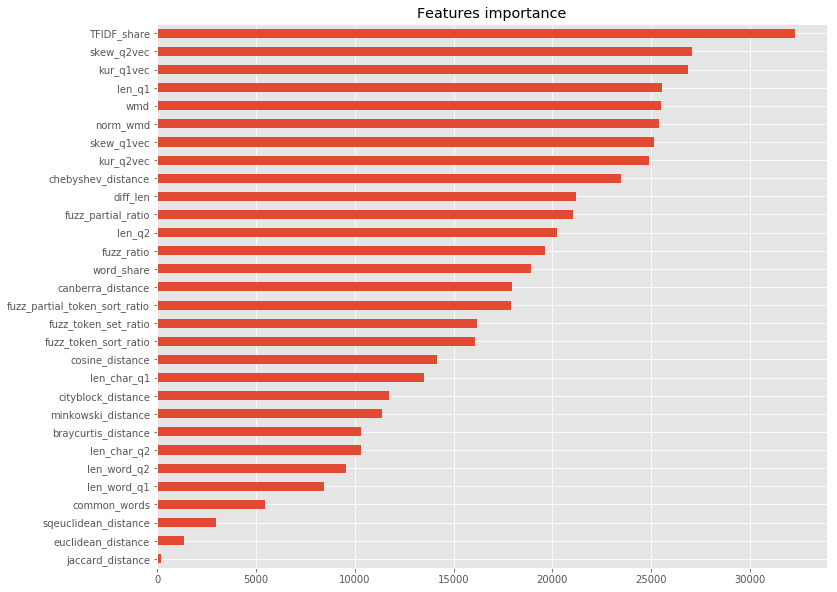

In [55]:
# Show feature importance levels
fig, ax = plt.subplots()
ts = pd.Series(xgbmodel.get_booster().get_fscore())
ts.sort_values(axis=0, ascending=True)
ax = ts.sort_values().plot(kind="barh", title="Features importance",
                           figsize=(12, 10), use_index=True)
ax.yaxis.label.set_color('#a2a2f7')
plt.show()


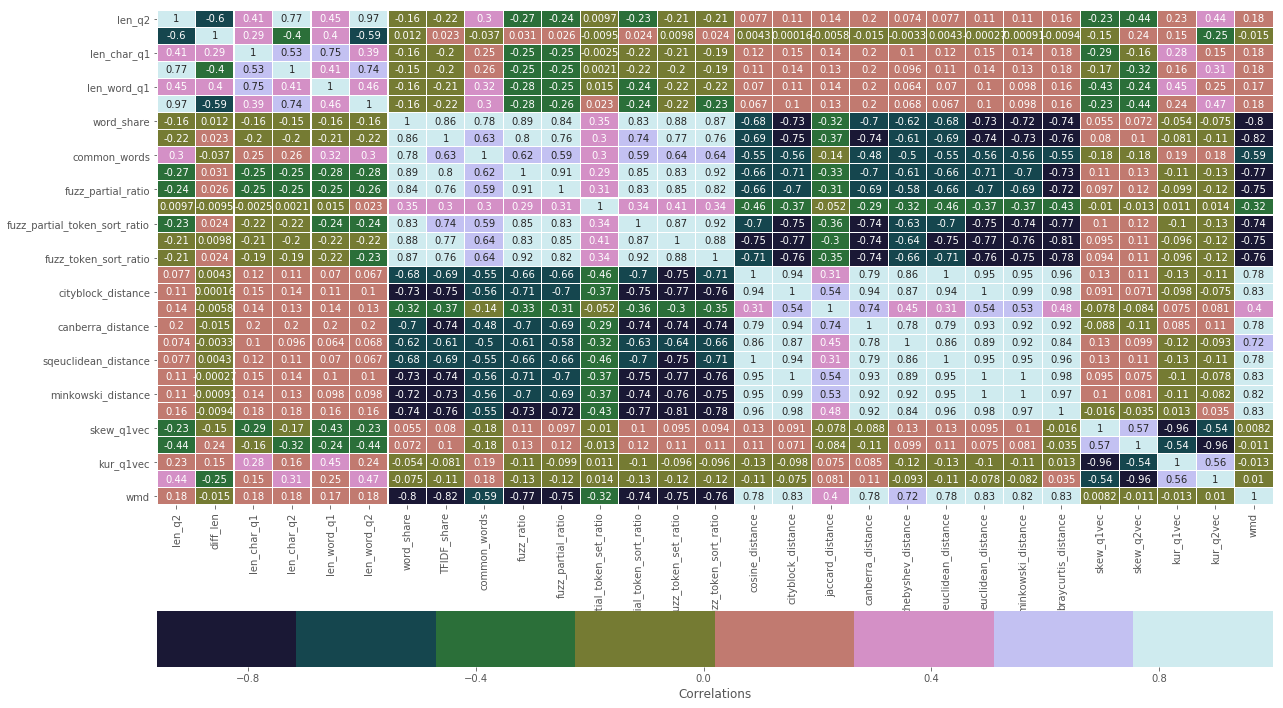

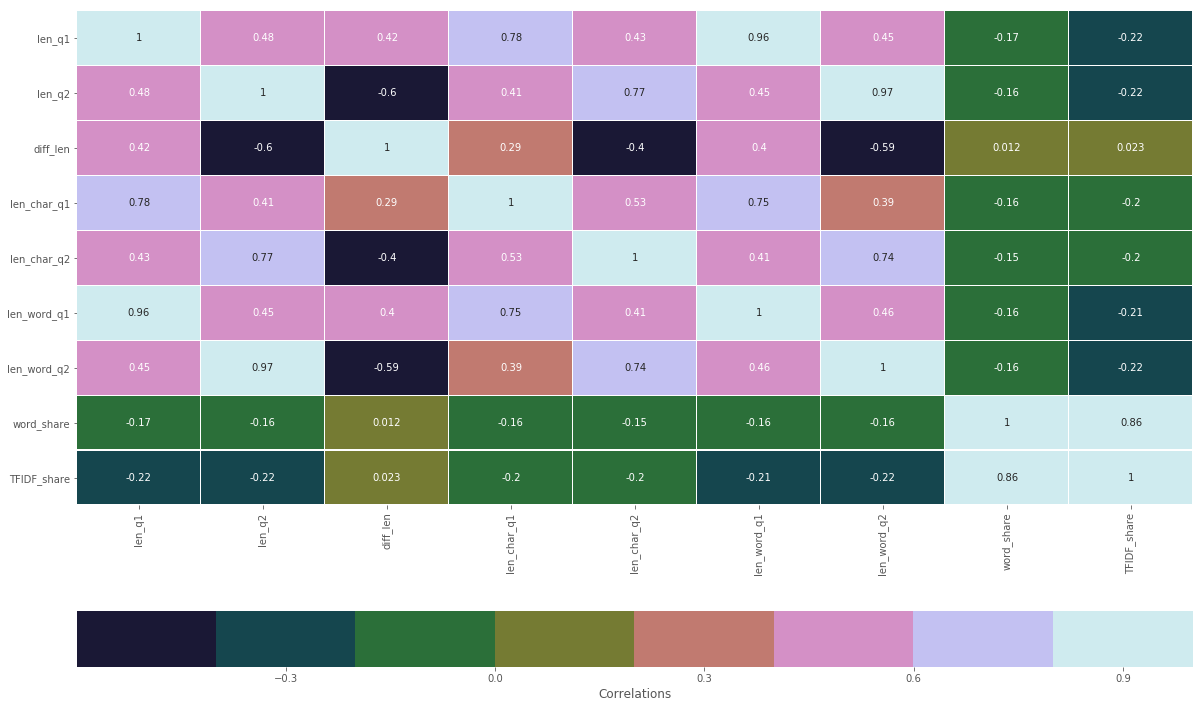

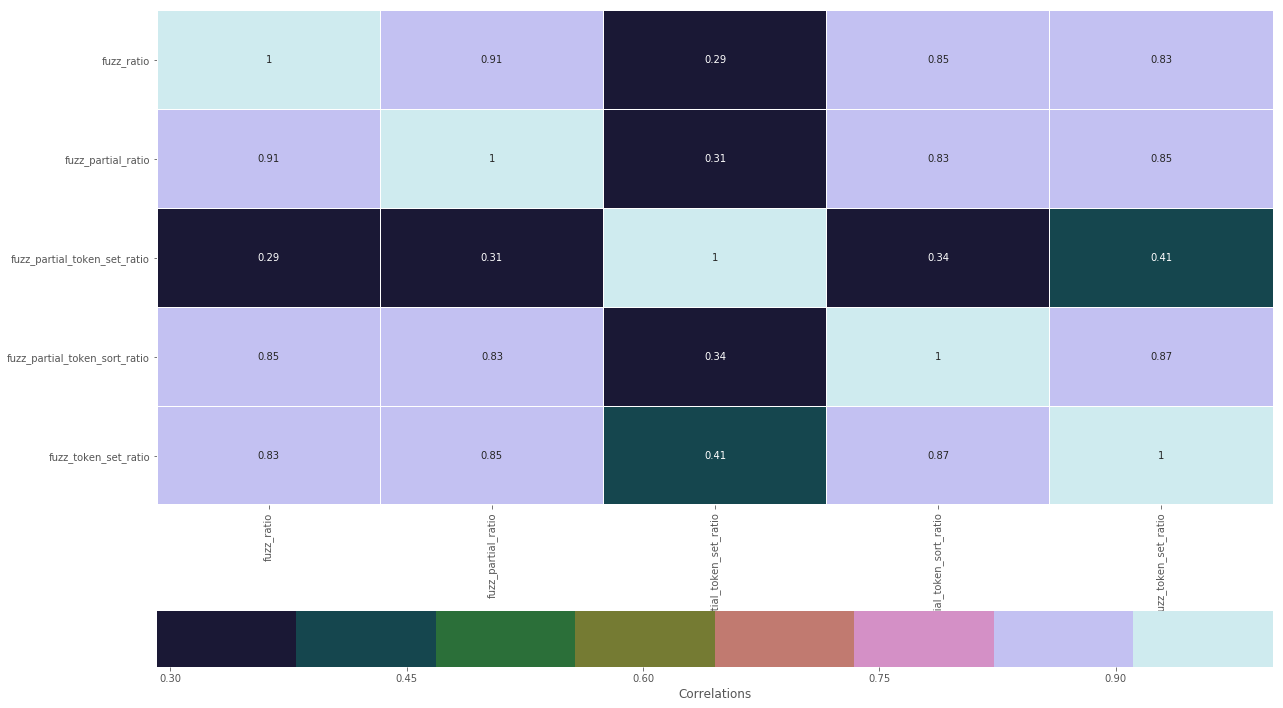

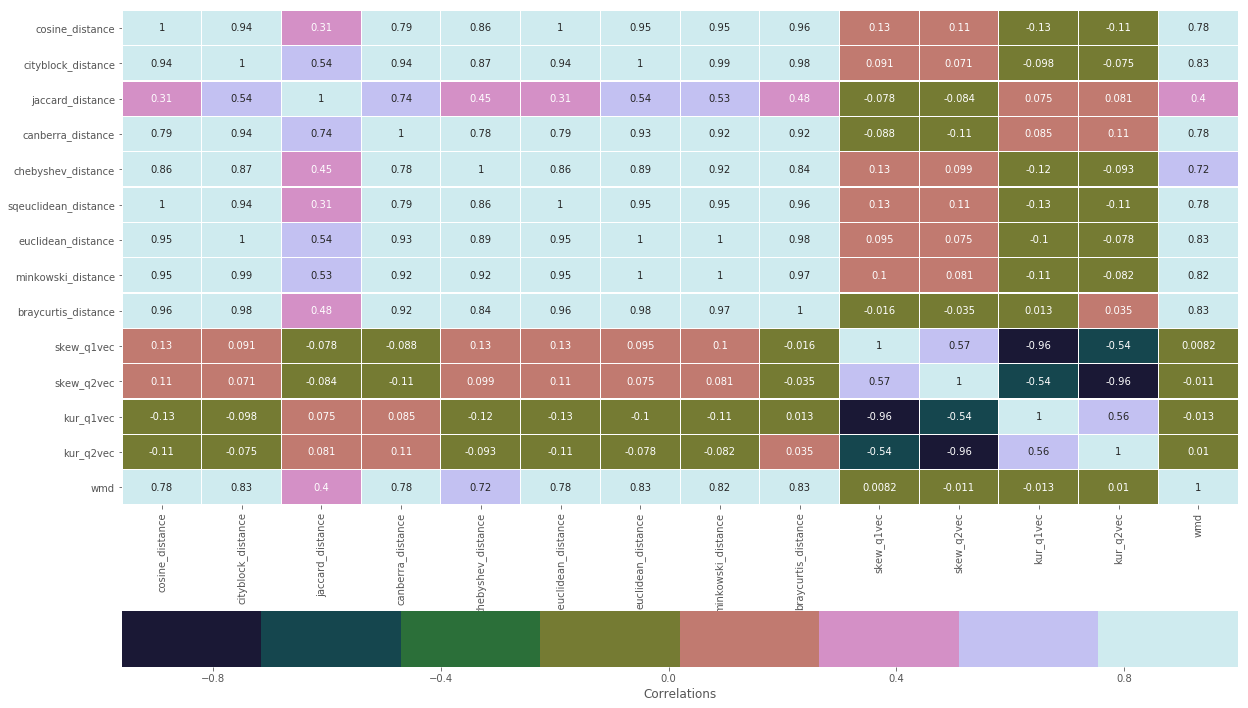

In [56]:
# Show heatmap features charts
heatmap_chart(train_df, features_list[1:30])  # All features
heatmap_chart(train_df, features_list[0:9])  # String Features
heatmap_chart(train_df, features_list[10:15])  # Fuzzy Ratio Features
heatmap_chart(train_df, features_list[16:30])  # Distance Features


In [57]:
# Import libraries
import datetime
import logging
import os
import warnings
from time import time

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
from scipy.spatial.distance import (
    braycurtis, canberra, chebyshev, cityblock, cosine, euclidean, jaccard,
    minkowski, sqeuclidean)
from scipy.stats import kurtosis, skew
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (
    KFold, cross_val_predict, cross_val_score, train_test_split)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from tqdm import tqdm_notebook

import xgboost as xgb
from graphs import heatmap_chart, pie_chart, histogram
from textcleaner import clean_text, drop_null, print_questions

warnings.filterwarnings("ignore")
start_nb = time()


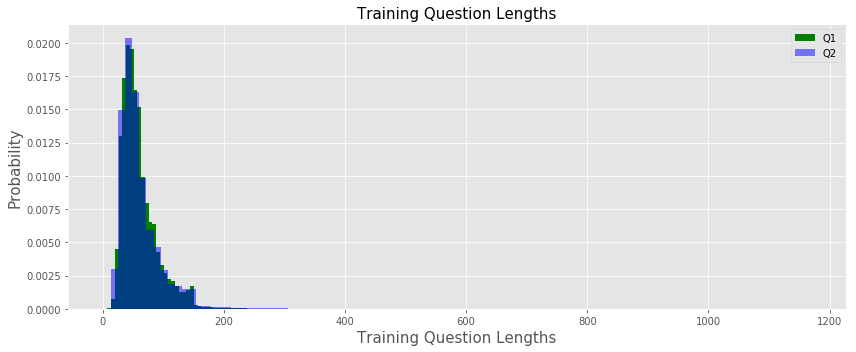

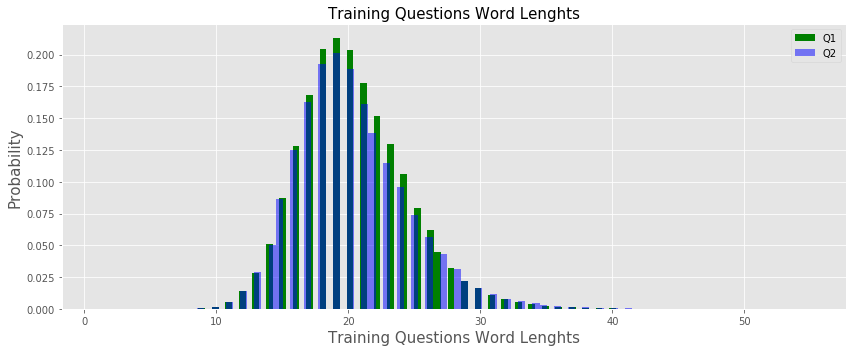

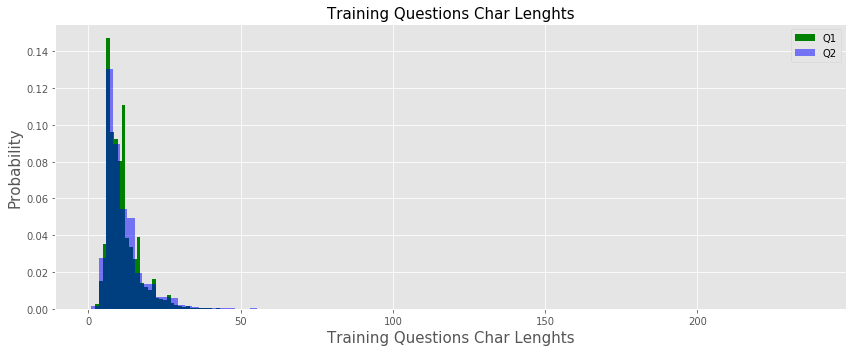

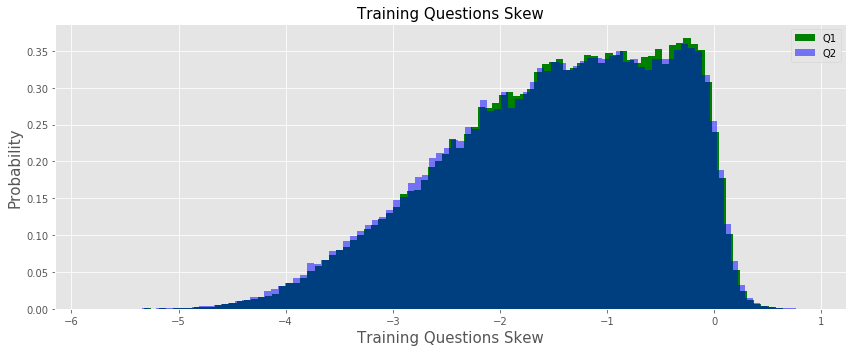

In [61]:
histogram("Training Question Lengths", train_df['len_q1'], train_df['len_q2'])
histogram("Training Questions Word Lenghts", train_df['len_char_q1'], train_df['len_char_q2'])
histogram("Training Questions Char Lenghts", train_df['len_word_q1'], train_df['len_word_q2'])
histogram("Training Questions Skew", train_df['skew_q1vec'], train_df['skew_q2vec'])
